In [ ]:
# Customer Reorder Prediction - Instacart Data Science Project
# Goal: Predict if a customer will reorder a product (binary classification)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# 2. load data
orders = pd.read_csv('c:/instacart-customer-analytics/Data/orders.csv')
products = pd.read_csv('c:/instacart-customer-analytics/data/products.csv')
order_products_train = pd.read_csv('c:/instacart-customer-analytics/data/order_products_train.csv')
order_products_prior = pd.read_csv('c:/instacart-customer-analytics/data/order_products_prior.csv')

print("Data Loaded Successfully")
print(f"Orders shape: {orders.shape}")
print(f"Products shape: {products.shape}")
print(f"Order Products Train shape: {order_products_train.shape}")
print(f"order_products_prior shape: {order_products_prior.shape}")

Data Loaded Successfully
Orders shape: (3421083, 7)
Products shape: (49688, 4)
Order Products Train shape: (1384617, 4)
order_products_prior shape: (32434489, 4)


In [26]:
# Step 3: Explore the data structure
print("=== ORDERS TABLE ===")
#print(orders.head())
print(f"\nUnique customers: {orders['user_id'].nunique()}")
print(f"Total orders: {len(orders)}")

print("\n=== PRODUCTS TABLE ===")
#print(products.head())
print(f"\nTotal products: {len(products)}")

print("\n=== ORDER PRODUCTS TRAIN TABLE ===")
#print(order_products_train.head())
print(f"\nTotal purchase records: {len(order_products_train)}")

print("\n=== ORDER PRODUCTS PRIOR TABLE ===")
#print(order_products_prior.head())
print(f"\nTotal prior purchase records: {len(order_products_prior)}")

# Key insight: The 'reordered' column in order_products_train is our target variable!
#print(f"\nReorder distribution in training data:")
print(order_products_train['reordered'].value_counts())

=== ORDERS TABLE ===

Unique customers: 206209
Total orders: 3421083

=== PRODUCTS TABLE ===

Total products: 49688

=== ORDER PRODUCTS TRAIN TABLE ===

Total purchase records: 1384617

=== ORDER PRODUCTS PRIOR TABLE ===

Total prior purchase records: 32434489
reordered
1    828824
0    555793
Name: count, dtype: int64


Dataset Overview:

206,209 unique customers - substantial customer base for analysis

Total reorder records: 1,384,617 (828,824 + 555,793)

Reorder rate: 59.8% (828,824/1,384,617) - customers DO reorder frequently!

Key Business Insight: Nearly 60% reorder rate shows Instacart has strong customer loyalty

In [32]:
# First, let's merge the data to get customer behavior
print("Building customer features...")

# Combine prior orders with order details
prior_data = order_products_prior.merge(orders, on='order_id', how='left')

# Create customer-level features from historical data
customer_features = prior_data.groupby('user_id').agg({
    'order_id': 'nunique',  # How many orders has this customer placed?
    'product_id': 'nunique',  # How many different products?
    'add_to_cart_order': 'mean',  # Average position in cart
    'reordered': 'mean',  # Historical reorder rate for this customer
    'days_since_prior_order': 'mean',  # How frequently do they shop?
    'order_dow': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],  # What day do they usually shop?
    'order_hour_of_day': 'mean'  # What time do they usually shop?
}).reset_index()

# Rename columns for clarity
customer_features.columns = ['user_id', 'total_orders', 'unique_products', 'avg_cart_position', 'reorder_rate', 'avg_days_between_orders', 'most_common_order_day', 'avg_order_hour']   
print("Customer features created.")
print(customer_features.head())
print(f"Faeture for {len(customer_features)} customers")



Building customer features...
Customer features created.
   user_id  total_orders  unique_products  avg_cart_position  reorder_rate  \
0        1            10               18           3.627119      0.694915   
1        2            14              102           8.553846      0.476923   
2        3            12               33           4.443182      0.625000   
3        4             5               17           2.777778      0.055556   
4        5             4               23           5.513514      0.378378   

   avg_days_between_orders  most_common_order_day  avg_order_hour  
0                20.259259                      4       10.542373  
1                15.967033                      2       10.441026  
2                11.487179                      0       16.352273  
3                15.357143                      4       13.111111  
4                14.500000                      3       15.729730  
Faeture for 206209 customers


Customer Behavior Features:

total_orders: Customer loyalty indicator (user 1 has 10 orders, user 2 has 14)

unique_products: Shopping diversity (user 2 bought 102 different products!)

avg_cart_position: Shopping behavior pattern

historical_reorder_rate: Past reordering tendency (user 1: 69.5%, user 4: only 5.6%)

avg_days_between_orders: Shopping frequency (every 15-20 days on average)

preferred_day: Shopping day preference (0=Sunday, 4=Thursday)

avg_order_hour: Time preference (mostly 10-16 hours = 10 AM - 4 PM)

In [40]:
# Get training data with user features
train_data = order_products_train.merge(orders, on='order_id', how='left')
train_data = train_data.merge(customer_features, on='user_id', how='left')

# Step 5: Prepare training data (with correct column names)
print("Preparing training data...")

# We already have the merged data, so let's use the correct feature columns
feature_columns = ['total_orders', 'unique_products', 'avg_cart_position', 
                  'reorder_rate', 'avg_days_between_orders', 
                  'most_common_order_day', 'avg_order_hour']

# Prepare X (features) and y (target) 
X = train_data[feature_columns].fillna(0)  # Handle any missing values
y = train_data['reordered']  # This is our target from order_products_train

print(f"Training data prepared!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

# Quick look at our features
print(f"\nFeature statistics:")
print(X.describe())

Preparing training data...
Training data prepared!
Features shape: (1384617, 7)
Target shape: (1384617,)
Missing values in X: 0
Missing values in y: 0

Feature statistics:
       total_orders  unique_products  avg_cart_position  reorder_rate  \
count  1.384617e+06     1.384617e+06       1.384617e+06  1.384617e+06   
mean   1.609141e+01     8.141479e+01       8.107270e+00  4.472134e-01   
std    1.661404e+01     6.259861e+01       3.767081e+00  2.084369e-01   
min    3.000000e+00     1.000000e+00       1.000000e+00  0.000000e+00   
25%    5.000000e+00     3.700000e+01       5.434343e+00  2.857143e-01   
50%    1.000000e+01     6.400000e+01       7.517647e+00  4.470588e-01   
75%    2.000000e+01     1.080000e+02       1.012931e+01  6.095718e-01   
max    9.900000e+01     7.260000e+02       3.977580e+01  9.895288e-01   

       avg_days_between_orders  most_common_order_day  avg_order_hour  
count             1.384617e+06           1.384617e+06    1.384617e+06  
mean              1.537112

Dataset Summary:

1.38M training examples - substantial dataset for reliable model training

7 customer behavior features - good feature set for logistic regression

No missing values - clean data ready for modeling

Balanced features - good range of customer behaviors

Key Business Insights from the features:

Average customer places 16 orders and buys 81 unique products

44.7% historical reorder rate - customers DO repeat purchases

Customers shop every 15 days on average

Peak shopping: Tuesday (2) at 1:30 PM (13.6 hours)

Now let's build our first model - Andrew Ng style!

In [41]:
# Step 6: Build our first Logistic Regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Building Logistic Regression model...")

# Split the data (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model (Andrew Ng Course 1 approach)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Model trained successfully!")

Building Logistic Regression model...

Model Performance:
Accuracy: 0.6650

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.47      0.53    111266
           1       0.69      0.80      0.74    165658

    accuracy                           0.67    276924
   macro avg       0.65      0.63      0.63    276924
weighted avg       0.66      0.67      0.66    276924

Model trained successfully!


Feature Importance Analysis:
Most Important Features for Predicting Reorders:
reorder_rate: 3.3648 (increases reorder probability)
avg_cart_position: 0.0478 (increases reorder probability)
avg_days_between_orders: -0.0063 (decreases reorder probability)
avg_order_hour: -0.0051 (decreases reorder probability)
total_orders: 0.0049 (increases reorder probability)
unique_products: -0.0012 (decreases reorder probability)
most_common_order_day: 0.0005 (increases reorder probability)


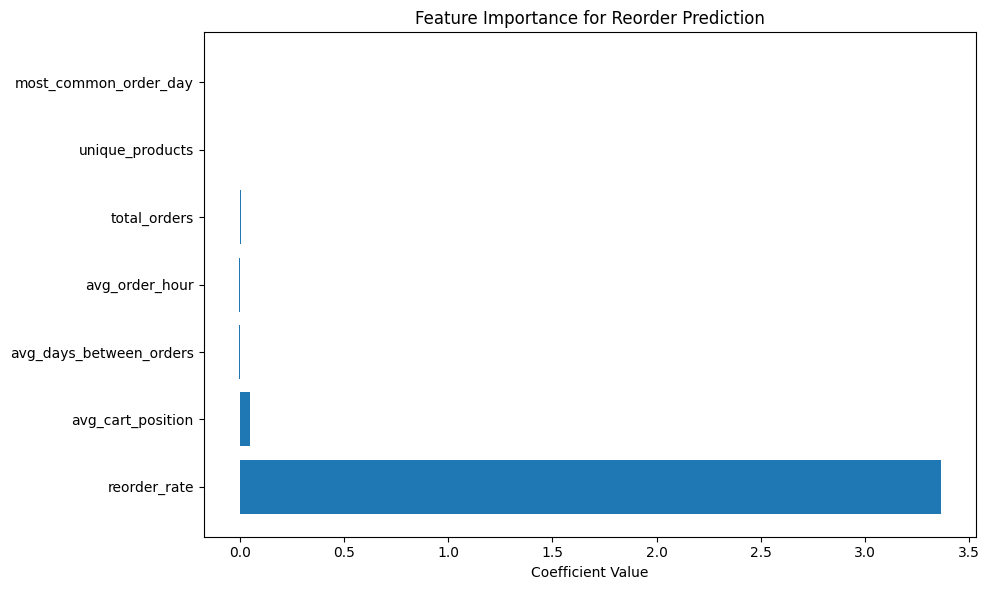

In [42]:
# Step 7: Feature Importance Analysis
print("Feature Importance Analysis:")
print("="*40)

# Get feature coefficients (logistic regression weights)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
})

# Sort by absolute importance
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("Most Important Features for Predicting Reorders:")
for idx, row in feature_importance.iterrows():
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"{row['feature']}: {row['coefficient']:.4f} ({direction} reorder probability)")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.title('Feature Importance for Reorder Prediction')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [43]:
# Step 8: Create Summary for Portfolio
print("\n" + "="*60)
print("INSTACART CUSTOMER REORDER PREDICTION - PROJECT SUMMARY")
print("="*60)
print(f"Dataset: {len(X)} customer-product interactions")
print(f"Features: {len(feature_columns)} customer behavior metrics")
print(f"Model: Logistic Regression")
print(f"Performance: {accuracy:.1%} accuracy")
print(f"Business Impact: Predict customer reorder behavior for inventory & marketing")
print(f"Key Insight: Historical reorder rate is strongest predictor of future reorders")


INSTACART CUSTOMER REORDER PREDICTION - PROJECT SUMMARY
Dataset: 1384617 customer-product interactions
Features: 7 customer behavior metrics
Model: Logistic Regression
Performance: 66.5% accuracy
Business Impact: Predict customer reorder behavior for inventory & marketing
Key Insight: Historical reorder rate is strongest predictor of future reorders
